In [1]:
import scipy
import numpy as np
from scipy.integrate import solve_ivp # ode solver
import matplotlib.pyplot as plt
import sympy
from math import *
from sympy.abc import x # for determining power series solving ODE in small time

Code for experimenting with the ODE
$$\ddot{y} + \frac{2}{t}\dot{y} - y + y^3 = 0$$
The goal is to experiment with various quantities so as to find facts that might be proven about this ODE in order to establish existence and uniqueness of the bound states

# Power series for initial condition

In [2]:
# Because there is a singularity at 0, we jumpstart our numerical solution using a power series
# Here we compute the coefficients of a power series giving small time solutions 
ps_coeffs = [1.0 * x, sympy.Poly(0.0, x, domain='RR')] # y(x,t) = ps_coeffs[0] + ps_coeffs[1] * t + ... for t small
NUM_COEFFS = 36
def get_coeff(k):
    cubed_val = 0
    for i in range(k-2+1):
        for j in range(k-2-i+1):
            l = k-2 - i - j
            s = ps_coeffs[i] * ps_coeffs[j] * ps_coeffs[l]
            cubed_val += s
    c = (ps_coeffs[k-2] - cubed_val) / (k*(k+1))
    c = sympy.expand(c)
    return c
print("computing power series coeffs")
for k in range(2,NUM_COEFFS+1):
    print("On coefficient:", k , "/", NUM_COEFFS)
    ps_coeffs.append(get_coeff(k))

computing power series coeffs
On coefficient: 2 / 36
On coefficient: 3 / 36
On coefficient: 4 / 36
On coefficient: 5 / 36
On coefficient: 6 / 36
On coefficient: 7 / 36
On coefficient: 8 / 36
On coefficient: 9 / 36
On coefficient: 10 / 36
On coefficient: 11 / 36
On coefficient: 12 / 36
On coefficient: 13 / 36
On coefficient: 14 / 36
On coefficient: 15 / 36
On coefficient: 16 / 36
On coefficient: 17 / 36
On coefficient: 18 / 36
On coefficient: 19 / 36
On coefficient: 20 / 36
On coefficient: 21 / 36
On coefficient: 22 / 36
On coefficient: 23 / 36
On coefficient: 24 / 36
On coefficient: 25 / 36
On coefficient: 26 / 36
On coefficient: 27 / 36
On coefficient: 28 / 36
On coefficient: 29 / 36
On coefficient: 30 / 36
On coefficient: 31 / 36
On coefficient: 32 / 36
On coefficient: 33 / 36
On coefficient: 34 / 36
On coefficient: 35 / 36
On coefficient: 36 / 36


In [3]:
# evaluate power series for initial condition
# b = y(0) is initial height, and t is initial time
# testing indicates that t = 0.01 is in the radius of convergence for b up to 200
def eval_initial_cond(b, t):
    y = 0
    yd = 0
    for k in range(0, len(ps_coeffs), 2):
        sv = ps_coeffs[k].subs(x, b)
        y += sv * t**k
        if k > 0:
            yd += k * sv * t**(k-1)
    return y, yd

In [4]:
ps_coeffs[-1]

1.7939329238847e-15*x**37 - 1.74341120020754e-14*x**35 + 7.71801200491412e-14*x**33 - 2.05822488346904e-13*x**31 + 3.68384884482493e-13*x**29 - 4.66575271638637e-13*x**27 + 4.29495049085038e-13*x**25 - 2.90447045161921e-13*x**23 + 1.44083094353884e-13*x**21 - 5.17569737430141e-14*x**19 + 1.31150415417883e-14*x**17 - 2.24319230051024e-15*x**15 + 2.40979863041629e-16*x**13 - 1.43995747206723e-17*x**11 + 3.83340147754501e-19*x**9 - 2.87368854229255e-21*x**7 + 2.05365034662494e-24*x**5 - 7.01334384951951e-30*x**3 + 7.26546017915307e-44*x

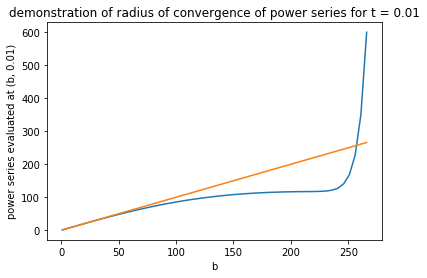

In [5]:
# verification that t = 0.01 is in radius of convergence for b < 200
xs = np.arange(1, 270, 5)
ys = [eval_initial_cond(x, 0.01)[0] for x in xs]
plt.plot(xs, ys)
plt.plot(xs, xs)
plt.xlabel("b")
plt.ylabel("power series evaluated at (b, 0.01)")
plt.title("demonstration of radius of convergence of power series for t = 0.01")
plt.show()

# Solving the ODE

In [135]:
# t is time, y = [y(t), y'(t)] is phase space vector
# returns derivative [y'(t), y''(t)]
def my_ode(t, y):
    return [y[1], -2*y[1]/t + y[0] - y[0]**3]

def my_ode2(t, y):
    return [y[1], -2*y[1]/t + y[0] - y[0]**6]

def make_ode_p(p):
    def the_ode(t,y):
        return [y[1], -2*y[1]/t + y[0] - y[0]**p]
    return the_ode

def make_ode_force(f):
    def the_ode_f(t,y):
        return [y[1], -2*y[1]/t + -f(y[0])]
    return the_ode_f

In [440]:
# we use scipy.integrate.solve_ivp to solve ode, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
# there are many options, here are some important ones:
# - 'method' is one of RK45, RK23, DOP853, Radau, BDF, LSODA. RK45 is the default, DOP853 is good for high precision
# - 't_eval' is the times at which to evaluate the solution
# - 'events' allows one to detect and evalute the ODE when conditions occur, such as y = 0 or y' = 0
# - 'atol' and 'rtol' are absolute and relative error tolerances. Total error must be within atol + |y| * rtol
# - 
t_min = 0.01

# b is the initial height, T is the time up to which to solve
# returns an object with several fields, the most important of which is sol.y, which gives the solution
def calc_sol(b, T, t_eval = None, **kwargs):
    if t_eval is None:
        t_eval = np.arange(t_min, T, 0.1)
    y, yd = eval_initial_cond(b, t_min)
    sol = solve_ivp(my_ode, [t_min, T], [y, yd], t_eval = t_eval, **kwargs)
    return sol

def calc_sol_arb(b, T, ode, t_eval = None, **kwargs):
    t_min = 1e-6
    y0 = b
    yd = 0
    sol = solve_ivp(ode, [t_min, T], [y0, yd], t_eval = t_eval, **kwargs)
    return sol

In [78]:
calc_sol(10, 50, atol=1e-10).y[0][-1]

-0.9915367547901591

In [475]:
def plot_sol(b, T, t_eval = None, atol = 1e-6, rtol = 1e-6, lab = None, **kwargs):
    if t_eval is None:
        t_eval = np.arange(t_min, T, 0.1)
    s = calc_sol(b, T, t_eval = t_eval, atol = atol, rtol = rtol, **kwargs)
    plt.plot(t_eval, s.y[0])
    
def plot_sol_arb(b, T, ode, t_eval = None, atol = 1e-6, rtol = 1e-6, lab = None, **kwargs):
    if t_eval is None:
        t_eval = np.arange(t_min, T, 0.1)
    s = calc_sol_arb(b, T, ode, t_eval = t_eval, atol = atol, rtol = rtol, **kwargs)
    l = {"label": lab} if lab != None else {}
    plt.plot(t_eval, s.y[0], **l)

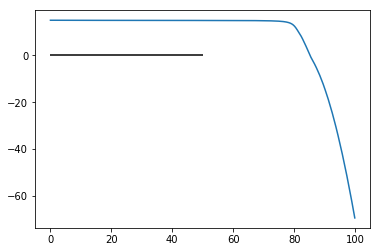

In [183]:
a = 70 # 3**(0.25)+0.1
def my_force_old(y):
    return -2*y*((5-y)/sqrt(0.1+y**4)) * cos(y/5)**2
def my_force(y):
    y = abs(y)
    return -10*y*((20-10*y)/sqrt(0.2+(10*y)**4)) * cos(sqrt(10*y))**2
def my_force_scaled(s):
    return lambda y: my_force(s * y)
# s = calc_sol_arb(a, 20, make_ode_force(my_force))
# print(min(s.y[0]))
force_ode = make_ode_force(my_force_scaled(2))
plot_sol_arb(15, 100, force_ode, rtol=1e-6)
plt.hlines(0, 0, 50)

T = 100
def at_large_time_arb(b, ode, tol=1e-8):
    return calc_sol_arb(b, T, ode, atol=tol, rtol=tol).y[0][-1]

bs = np.arange(1, 50, 1)
ys = [at_large_time_arb(b, force_ode, tol=1e-4) for b in bs]
plt.plot(bs, ys)
plt.xlabel("initial y")
plt.ylabel("y(50)")
plt.title("Position at time 50 for various initial heights, showing excited states")

In [141]:
my_force(6)

0.18965806182697623

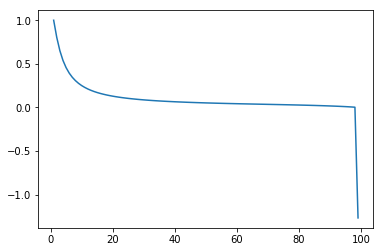

In [129]:
def min_achieved(b, p):
    s = calc_sol_arb(b, 20, make_ode_p(p), atol=1e-8, rtol = 1e-8)
    return min(s.y[0])
#     plot_sol_arb(a, 100, make_ode_p(5))
#     plt.hlines(0, 0, 100)

all_b = np.arange(1, 100, 1)
p = 5
all_min = [min_achieved(b, 5) for b in all_b]
plt.plot(all_b, all_min)

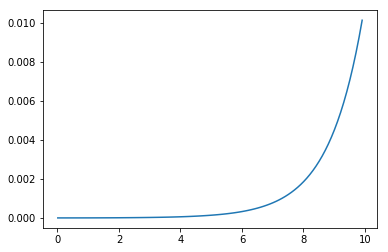

In [73]:
plot_sol_arb(4, 10, my_ode)

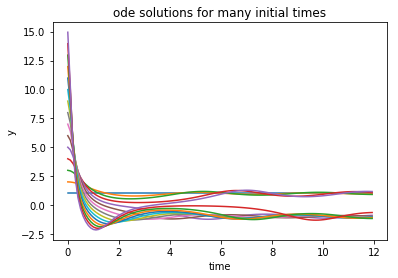

In [10]:
# example with many starting values
T = 12
max_height = 16
t = np.arange(0.01, T - 1, 0.1)
for b in np.arange(1, max_height, 1):
    plot_sol(b, T)
plt.xlabel("time")
plt.ylabel("y")
plt.title("ode solutions for many initial times")
plt.show()

# Calculating excited states

Text(0.5, 1.0, 'Position at time 50 for various initial heights, showing excited states')

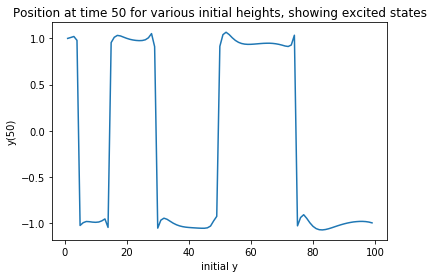

In [11]:
# we can get a sense of the excited states with the following graph
# this shows position at time 50 for varying initial values b
T = 50
def at_large_time(b, tol=1e-8):
    return calc_sol(b, T, atol=tol, rtol=tol).y[0][-1]

bs = np.arange(1, 100, 1)
ys = [at_large_time(b, tol=1e-4) for b in bs]
plt.plot(bs, ys)
plt.xlabel("initial y")
plt.ylabel("y(50)")
plt.title("Position at time 50 for various initial heights, showing excited states")

## We see here that the excited states are approximately 4, 15, 30, 45, 75, ...
## We compute them numerically using a binary search

In [12]:
# find an excited state inbetween l and u using binary search
def find_excited_state(l, u, tol = 1e-8):
    v1 = (at_large_time(u) > 0)
    v2 = (at_large_time(l) > 0)
    
    if v1 == v2:
        return "lower and upper go into same well"

    i = 1
    while u - l > tol:
        m = (u+l)/2
        if i % 10 == 0:
            print("{:2d}: m = {:.10f}, rat = {:e}".format(i, m, (u-l)/tol))
        
        lt = at_large_time(m, tol) > 0
        if lt == v1:
            u = m
        else:
            l = m
        
        i += 1
    
    return m

10: m = 4.3330078125, rat = 1.367188e+06
20: m = 4.3373937607, rat = 1.335144e+03
30: m = 4.3373877043, rat = 1.303852e+00


Text(0.5, 1.0, 'ode solution for ground state')

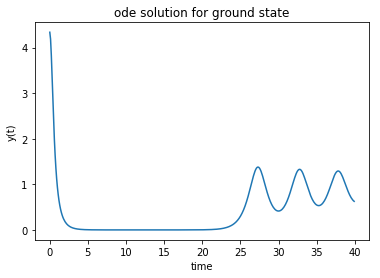

In [14]:
m = find_excited_state(3, 10)
plot_sol(m, 40, atol = 1e-8, rtol=1e-8)
plt.xlabel("time")
plt.ylabel("y(t)")
plt.title("ode solution for ground state")

In [504]:
b0 = find_excited_state(3, 7)
b1 = find_excited_state(7, 20)
b2 = find_excited_state(20, 40)
b3 = find_excited_state(40, 60)
b4 = find_excited_state(60, 80)

10: m = 4.3398437500, rat = 7.812500e+05
20: m = 4.3373908997, rat = 7.629395e+02
10: m = 14.0966796875, rat = 2.539062e+06
20: m = 14.1035852432, rat = 2.479553e+03
30: m = 14.1035847226, rat = 2.421439e+00
10: m = 29.1210937500, rat = 3.906250e+06
20: m = 29.1312217712, rat = 3.814697e+03
30: m = 29.1312123276, rat = 3.725290e+00
10: m = 49.3554687500, rat = 3.906250e+06
20: m = 49.3607139587, rat = 3.814697e+03
30: m = 49.3607112579, rat = 3.725290e+00
10: m = 74.7851562500, rat = 3.906250e+06
20: m = 74.7723197937, rat = 3.814697e+03
30: m = 74.7723053209, rat = 3.725290e+00


In [505]:
bound_states = [b0, b1, b2, b3, b4]
for i,b in enumerate(bound_states):
    print("b{:d} = {:13.10f}".format(i, b))

b0 =  4.3373877034
b1 = 14.1035847287
b2 = 29.1312123369
b3 = 49.3607112672
b4 = 74.7723053303


Text(0.5, 1.0, 'ODE solutions for first few bound states')

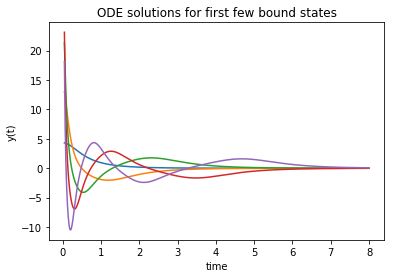

In [17]:
for b in bound_states:
    plot_sol(b, 30, t_eval = np.arange(0.05, 8, 0.01))
    
plt.xlabel("time")
plt.ylabel("y(t)")
plt.title("ODE solutions for first few bound states")

# Curves in phase space

In [312]:
# we use the "events" option in scipy.integrate.solve_ivp
def at_0(t, y): return y[0]
def at_left_well(t,y): return y[0] + 1
def at_right_well(t,y): return y[0] - 1
def stationary(t,y): return y[1]

def calc_event(b, T, func, n = 0, rtol=1e-5, atol=1e-7, **kwargs):
    y, yd = eval_initial_cond(b, t_min)
    
    sol = solve_ivp(my_ode, [t_min, T], [y, yd], events = func, dense_output = True, rtol=rtol, atol=atol, **kwargs)
    if len(sol.t_events[0]) <= n:
        return None
    te = sol.t_events[0][n]
    return te, sol.sol(te)

Text(0.5, 1.0, 'time & velocity achieved by ball hitting y = 1 for first time')

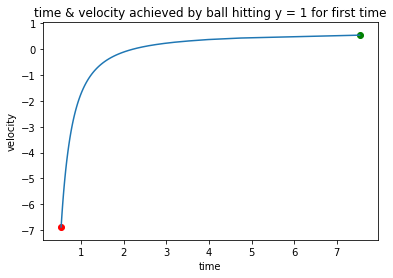

In [19]:
# calculates all the pairs (t, y') that appear 
# as the time & velocity of the particle reaching the bottom of the first well for the first time
# green is initial y small, and red is initial y large
all_t = []
all_v = []
initial_range = np.arange(0.01, 10, 0.1)
input_one = 10

for b in initial_range:
    res = calc_event(b, 30, at_right_well, n=0, rtol=1e-3, atol=1e-5)
    if res == None:
        continue
    else:
        t, y = res
    all_t.append(t)
    all_v.append(y[1])
    
plt.plot(all_t, all_v)
plt.scatter(all_t[0], all_v[0], color='green')
plt.scatter(all_t[-1], all_v[-1], color='red')
# plt.scatter(all_t[input_one], all_v[input_one], color='purple')
plt.xlabel("time")
plt.ylabel("velocity")
plt.title("time & velocity achieved by ball hitting y = 1 for first time")

Text(0.5, 1.0, 'time & velocity achieved by ball hitting y = 1 for fifth time')

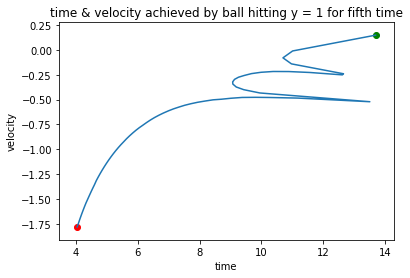

In [20]:
# this is the time and velocity when y = 1 for the fifth time
# the different parts come from how many times 0 has been crossed
all_t = []
all_v = []
initial_range = np.arange(0.11, 100, 1)

for b in initial_range:
    res = calc_event(b, 30, at_right_well, n=4, rtol=1e-3, atol=1e-5)
    if res == None:
        continue
    else:
        t, y = res
    all_t.append(t)
    all_v.append(y[1])
    
plt.plot(all_t, all_v)
plt.scatter(all_t[0], all_v[0], color='green')
plt.scatter(all_t[-1], all_v[-1], color='red')
plt.xlabel("time")
plt.ylabel("velocity")
plt.title("time & velocity achieved by ball hitting y = 1 for fifth time")

Text(0.5, 1.0, 'Height reached on LHS as function of initial y')

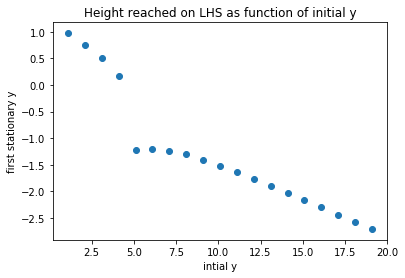

In [21]:
# height on the LHS as a function of height on the RHS
# the discontinuity is due to the first crossing and occurs at y = b0
all_h = []
initial_range = np.arange(1.1, 20, 1)

for b in initial_range:
    res = calc_event(b, 30, stationary, n=0, rtol=1e-3, atol=1e-5)
    if res == None:
        continue
    else:
        t, y = res
    all_h.append(y[0])
    
plt.scatter(initial_range, all_h)
plt.xlabel("intial y")
plt.ylabel("first stationary y")
plt.title("Height reached on LHS as function of initial y")


Text(0.5, 1.0, 'Time to hit center as a function of initial y')

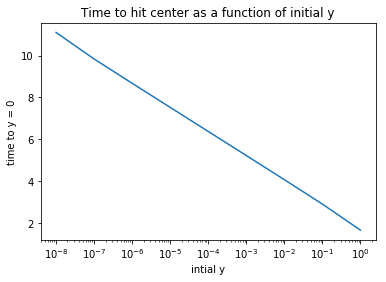

In [22]:
# time to reach y = 0 as a function of height on the RHS
all_t = []
initial_range = b0 + np.array([10**(-k) for k in range(30)]) # np.arange(1.1, 20, 1)
xs = []

for b in initial_range:
    res = calc_event(b, 30, at_0, n=0, rtol=1e-8, atol=1e-8)
    if res == None:
        continue
    else:
        t, y = res
        
    xs.append(b-b0)
    all_t.append(t)
    
plt.plot(xs, all_t)
# plt.yscale("log")
plt.xscale("log")
plt.xlabel("intial y")
plt.ylabel("time to y = 0")
plt.title("Time to hit center as a function of initial y")


Text(0.5, 1.0, 'Velocity at center as a function of initial y')

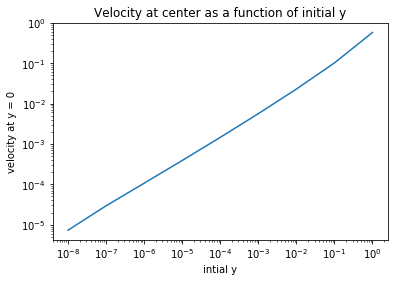

In [23]:
# velocity at reach y = 0 as a function of height on the RHS
all_v = []
initial_range = b0 + np.array([10**(-k) for k in range(30)]) # np.arange(1.1, 20, 1)
xs = []

for b in initial_range:
    res = calc_event(b, 30, at_0, n=0, rtol=1e-8, atol=1e-8)
    if res == None:
        continue
    else:
        t, y = res
        
    xs.append(b-b0)
    all_v.append(-y[1])
    
plt.plot(xs, all_v)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("intial y")
plt.ylabel("velocity at y = 0")
plt.title("Velocity at center as a function of initial y")


Text(0.5, 1.0, 'time & velocity achieved by ball hitting y = 0 for first time')

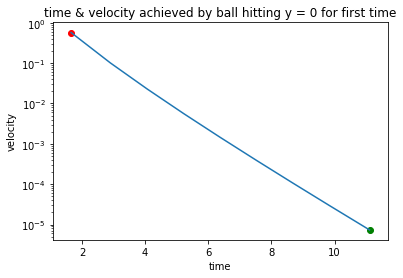

In [24]:
# time and velocity when y = 0 for first time 
all_t = []
all_v = []
initial_range = b0 + np.array([10**(-k) for k in range(30)])
input_one = 10

for b in initial_range:
    res = calc_event(b, 30, at_0, n=0, rtol=1e-8, atol=1e-8)
    if res == None:
        continue
    else:
        t, y = res
    all_t.append(t)
    all_v.append(-y[1])
    
plt.plot(all_t, all_v)
plt.scatter(all_t[0], all_v[0], color='red')
plt.scatter(all_t[-1], all_v[-1], color='green')
plt.yscale("log")
# plt.scatter(all_t[input_one], all_v[input_one], color='purple')
plt.xlabel("time")
plt.ylabel("velocity")
plt.title("time & velocity achieved by ball hitting y = 0 for first time")

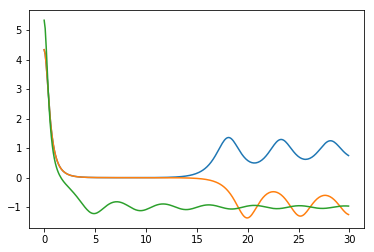

In [25]:
plot_sol(b0, 30)
plot_sol(b0+1e-5, 30)
plot_sol(b0+1, 30)

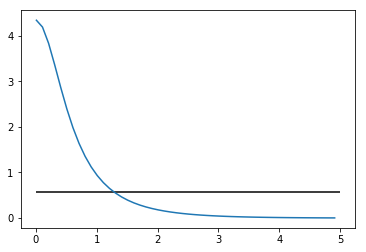

In [26]:
plot_sol(b0, 5)
plt.hlines(1/sqrt(3), 0, 5)

# Energy

In [28]:
def energy(y):
    return y[1]**2 / 2 + y[0]**4/4 - y[0]**2/2

Text(0.5, 1.0, 'energy as a function of time starting at b = 5')

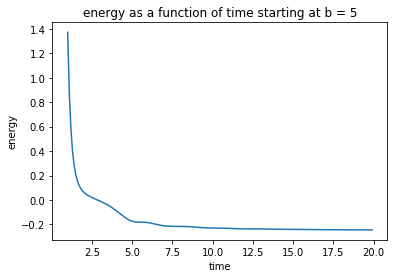

In [27]:
b = 5
T = 50
times = np.arange(1, 20, 0.1)
s = calc_sol(b, T, t_eval = times)
e = [energy(y) for y in zip(s.y[0], s.y[1])]
plt.plot(times, e)
plt.xlabel("time")
plt.ylabel("energy")
plt.title("energy as a function of time starting at b = 5")

# First variation

Text(0.5, 1.0, 'first variation dy/db(t) at b = b0')

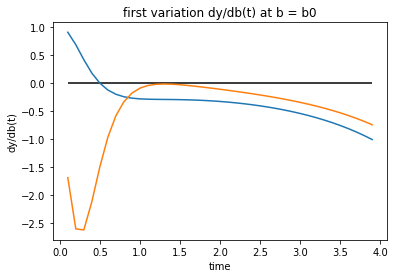

In [28]:
# plot of first variation at first ground state
b = b0
T = 4
ep = 1e-4
times = np.arange(0.1, T, 0.1)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
delta = (s2.y[0] - s1.y[0]) / ep
deltav = (s2.y[1] - s1.y[1]) / ep
plt.plot(times, delta)
plt.plot(times, deltav)
plt.hlines(0, times[0], times[-1])
plt.xlabel("time")
plt.ylabel("dy/db(t)")
plt.title("first variation dy/db(t) at b = b0")

Text(0.5, 1.0, 'first variation dy/db(t) at b = b1')

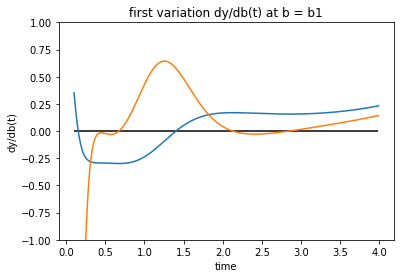

In [29]:
# plot of first variation at first excited state
b = b1
T = 4
ep = 1e-4
times = np.arange(0.1, T, 0.01)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
delta = (s2.y[0] - s1.y[0]) / ep
deltav = (s2.y[1] - s1.y[1]) / ep
plt.plot(times, delta)
plt.plot(times, deltav)
plt.hlines(0, times[0], times[-1])
plt.ylim(-1, 1)
plt.xlabel("time")
plt.ylabel("dy/db(t)")
plt.title("first variation dy/db(t) at b = b1")

In [30]:
print("{}, {}".format(delta[53], delta[54]))
s1.y[0][53]

-0.2979071955799828, -0.29809609172315454


-0.8100085289190933

Text(0.5, 1.0, 'first variation dy/db(t) at b = b1')

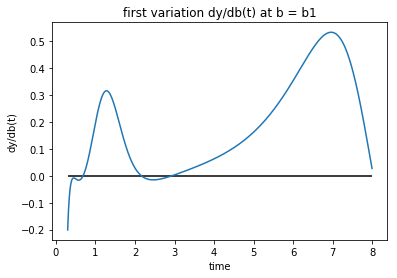

In [31]:
# plot of first variation at first excited state
b = b1
a = b1 - 0.5
ep = a - b
T = 8
times = np.arange(0.3, T, 0.01)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(a, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
delta = (s2.y[0] - s1.y[0]) / ep
deltav = (s2.y[1] - s1.y[1]) / ep
plt.plot(times, s1.y[1] - s2.y[1])
# plt.plot(times, s2.y[1])
plt.hlines(0, times[0], times[-1])
# plt.ylim(-0.1, 0.1)
plt.xlabel("time")
plt.ylabel("dy/db(t)")
plt.title("first variation dy/db(t) at b = b1")

Text(0.5, 1.0, 'first variation dy/db(t) at b = b2')

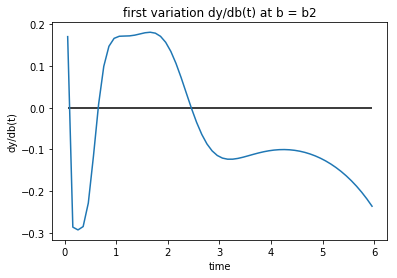

In [32]:
# plot of first variation at second excited state
b = b2
T = 6
ep = 1e-4
times = np.arange(0.06, T, 0.1)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
delta = (s2.y[0] - s1.y[0]) / ep
plt.plot(times, delta)
plt.hlines(0, times[0], times[-1])
plt.xlabel("time")
plt.ylabel("dy/db(t)")
plt.title("first variation dy/db(t) at b = b2")

Text(0.5, 1.0, 'first variation dy/db(t) at b = b3')

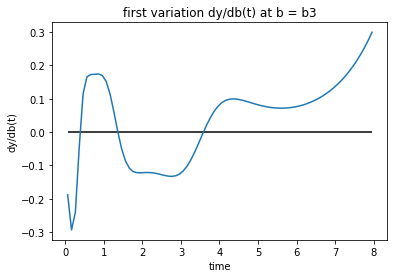

In [33]:
# plot of first variation at third excited state
b = b3
T = 8
ep = 1e-4
times = np.arange(0.06, T, 0.1)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
delta = (s2.y[0] - s1.y[0]) / ep
plt.plot(times, delta)
plt.hlines(0, times[0], times[-1])
plt.xlabel("time")
plt.ylabel("dy/db(t)")
plt.title("first variation dy/db(t) at b = b3")

Text(0.5, 1.0, 'first variation dE/db(t) at b = b0')

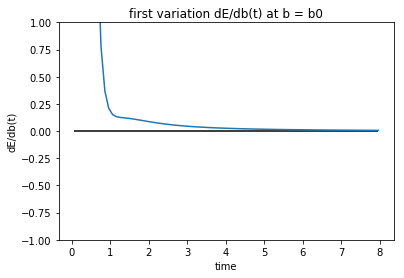

In [34]:
# plot of first variation of energy at ground state
b = b0
T = 8
ep = 1e-7
times = np.arange(0.06, T, 0.1)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
e1 = np.array([energy((a,b)) for a,b in zip(s1.y[0], s1.y[1])])
e2 = np.array([energy((a,b)) for a,b in zip(s2.y[0], s2.y[1])])
delta = (e2 - e1) / ep

plt.plot(times, delta)
plt.ylim(-1, 1)
plt.hlines(0, times[0], times[-1])
plt.xlabel("time")
plt.ylabel("dE/db(t)")
plt.title("first variation dE/db(t) at b = b0")

Text(0.5, 1.0, 'first variation dE/db(t) at b = b1')

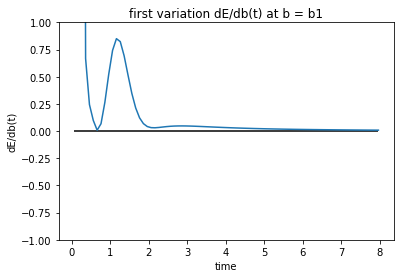

In [35]:
# plot of first variation of energy at first excited state
b = b1
T = 8
ep = 1e-7
times = np.arange(0.06, T, 0.1)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
e1 = np.array([energy((a,b)) for a,b in zip(s1.y[0], s1.y[1])])
e2 = np.array([energy((a,b)) for a,b in zip(s2.y[0], s2.y[1])])
delta = (e2 - e1) / ep

plt.plot(times, delta)
plt.ylim(-1, 1)
plt.hlines(0, times[0], times[-1])
plt.xlabel("time")
plt.ylabel("dE/db(t)")
plt.title("first variation dE/db(t) at b = b1")

Text(0.5, 1.0, 'first variation dE/db(t) at b = b2')

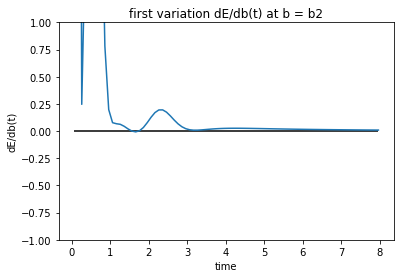

In [36]:
# plot of first variation of energy at second excited state
b = b2
T = 8
ep = 1e-7
times = np.arange(0.06, T, 0.1)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
e1 = np.array([energy((a,b)) for a,b in zip(s1.y[0], s1.y[1])])
e2 = np.array([energy((a,b)) for a,b in zip(s2.y[0], s2.y[1])])
delta = (e2 - e1) / ep

plt.plot(times, delta)
plt.ylim(-1, 1)
plt.hlines(0, times[0], times[-1])
plt.xlabel("time")
plt.ylabel("dE/db(t)")
plt.title("first variation dE/db(t) at b = b2")

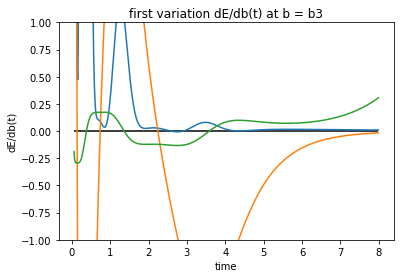

In [37]:
# plot of first variation of energy at third excited state
b = b3
T = 8
ep = 1e-4
times = np.arange(0.06, T, 0.01)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
e1 = np.array([energy((a,b)) for a,b in zip(s1.y[0], s1.y[1])])
e2 = np.array([energy((a,b)) for a,b in zip(s2.y[0], s2.y[1])])
delta = (e2 - e1) / ep

plt.plot(times, delta)
plt.ylim(-1, 1)
plt.hlines(0, times[0], times[-1])
plt.xlabel("time")
plt.ylabel("dE/db(t)")
plt.title("first variation dE/db(t) at b = b3")
# plt.show()

plt.plot(times, s1.y[0])
plt.plot(times, (s2.y[0] - s1.y[0]) / ep)
plt.show()

# Velocity as a function of height

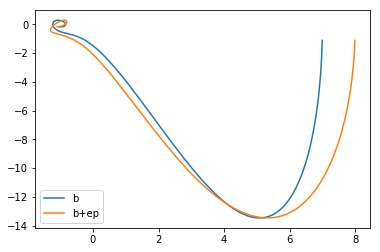

In [38]:
b = 7
ep = 1
T = 7
times = np.arange(0.01, T, 0.005)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
# E1 = [energy(a,b) for a,b in zip(s1.y[0], s1.y[1])]
# E2 = [energy(a,b) for a,b in zip(s2.y[0], s2.y[1])]
plt.plot(s1.y[0], s1.y[1], label="b")
plt.plot(s2.y[0], s1.y[1], label="b+ep")
# plt.xlim(3.5, 5.5)
# plt.ylim(-14,-10)
plt.legend()
plt.show()

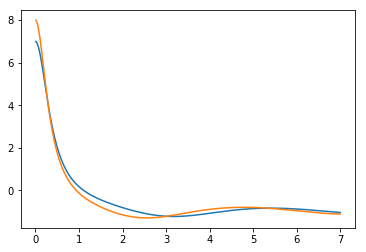

In [39]:
plt.plot(times, s1.y[0])
plt.plot(times, s2.y[0])

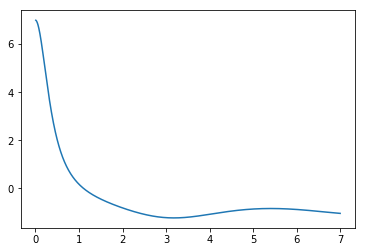

In [40]:
plt.plot(times, s1.y[0])

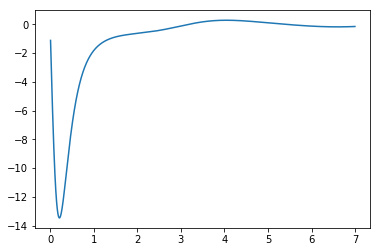

In [41]:
plt.plot(times, s1.y[1])

(-1, 1)

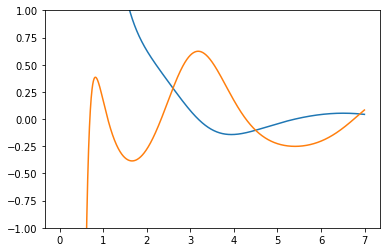

In [42]:
plt.plot(times, -2*s1.y[1]/s1.t)
plt.plot(times,  s1.y[0] - s1.y[0]**3)
plt.ylim(-1, 1)

(-1, 1)

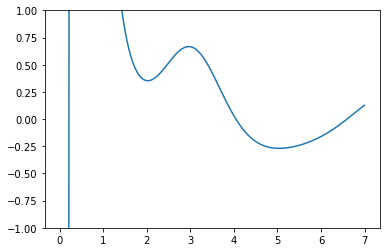

In [43]:
plt.plot(times, -2*s1.y[1]/s1.t + s1.y[0] - s1.y[0]**3)
plt.ylim(-1, 1)

# Action as a function of time

In [44]:
def action(y):
    return y[1]**2 / 2 - (y[0]**4 / 4 - y[0]**2 / 2) # KE - PE

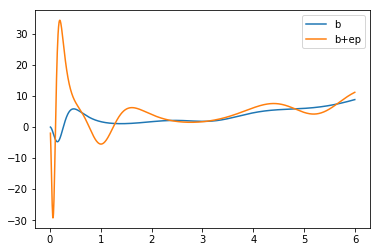

In [45]:
b = 7
ep = 10
T = 6
times = np.arange(0.01, T, 0.005)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
A1 = [t**2 * action((a,b)) for t,a,b in zip(s1.t, s1.y[0], s1.y[1])]
A2 = [t**2 * action((a,b)) for t,a,b in zip(s2.t, s2.y[0], s2.y[1])]
plt.plot(s1.t, A1, label="b")
plt.plot(s2.t, A2, label="b+ep")
# plt.xlim(3.5, 5.5)
# plt.ylim(-14,-10)
plt.legend()
plt.show()

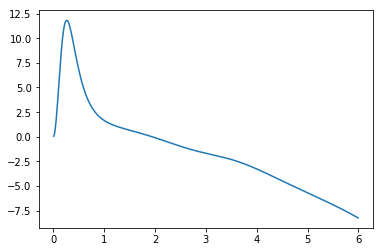

In [46]:
TE = np.array([t**2 * energy((a,b)) for t,a,b in zip(s1.t, s1.y[0], s1.y[1])])
plt.plot(s1.t, TE)

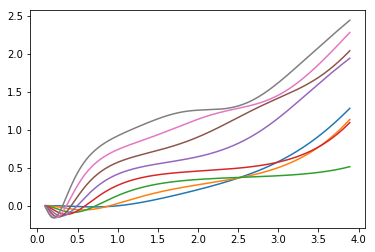

In [47]:
all_b = np.arange(2, 10, 1) # [5, 10]
T = 4
times = np.arange(0.1, T-0.1, 0.01)
for b in all_b:
    s = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
    A = [t**2 * action((a,b)) for t,a,b in zip(s.t, s.y[0], s.y[1])]
    A_cs = np.cumsum(A) / len(A)
    plt.plot(s.t, A_cs, label="b=" + str(b))
# plt.legend()
plt.show()

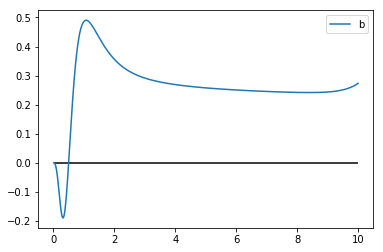

In [48]:
b = b0
ep = 1e-5
T = 10
times = np.arange(0.01, T, 0.005)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-10, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-10, atol = 1e-8)
v = [t**2 * v1 * (p2-p1)/ep  for t,p1, v1, p2 in zip(s1.t, s1.y[0], s1.y[1], s2.y[0])]
plt.plot(s1.t, v, label="b")
plt.hlines(0, s1.t[0], s1.t[-1])
# plt.xlim(3.5, 5.5)
# plt.ylim(-14,-10)
plt.legend()
plt.show()

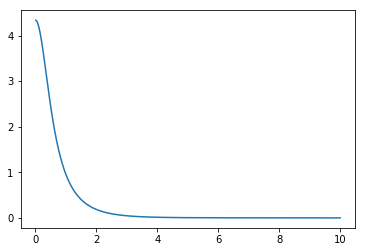

In [49]:
plt.plot(times, s2.y[0])

# Energy Loss

In [50]:
a = b0
b = b0+1e-5
ep = b - a
T = 2
t_eval = np.arange(1.0, T, 0.1)

# calc_sol(a, T, rtol=1e-8, atol=1e-8)
# calc_sol(b, T, rtol=1e-8, atol=1e-8)

s1 = solve_ivp(my_ode, [1.0, T], [a, 0], t_eval = t_eval) 
s2 = solve_ivp(my_ode, [1.0, T], [b, 0], t_eval = t_eval) 
E1_i = energy([a, 0])
E1_f = energy([s1.y[0][-1], s1.y[1][-1]])
E2_i = energy([b, 0])
E2_f = energy([s2.y[0][-1], s2.y[1][-1]])
DE_1 = E1_i - E1_f
DE_2 = E2_i - E2_f
s = (DE_2-DE_1)/ep
s

66.9417094283394

In [51]:
(E2_i - E1_i)/ep

77.26186980087598

In [52]:
E1_i, E1_f

(79.07513740406665, 10.949188048911223)

# Energy variation calcs

Text(0.5, 1.0, 'first variation dE/db(t) at b = b0')

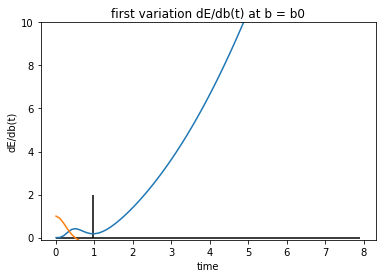

In [65]:
# plot of first variation of energy at ground state
b = b0
T = 8
ep = 1e-7
times = np.arange(0.01, T, 0.1)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
e1 = np.array([energy((a,b)) for t,a,b in zip(s1.t, s1.y[0], s1.y[1])])
e2 = np.array([energy((a,b)) for t,a,b in zip(s2.t, s2.y[0], s2.y[1])])
deltay = [(y2 - y1) / ep for y1, y2 in zip(s1.y[0], s2.y[0])]
delta = [t**4 * (e2 - e1) / ep for t, e1, e2 in zip(s1.t, e1, e2)]

res = calc_event(b0, 8, at_right_well)

plt.plot(times, delta)
plt.plot(times, deltay)
plt.ylim(-0.1, 10)
plt.hlines(0, times[0], times[-1])
plt.vlines(res[0], 0, 2)
plt.xlabel("time")
plt.ylabel("dE/db(t)")
plt.title("first variation dE/db(t) at b = b0")

In [61]:
res

(0.9717073874521486, array([ 1.        , -1.84488802]))

# Graphs comparing energies

Text(0.5, 1.0, 'first variation dE/db(t) at b = b0')

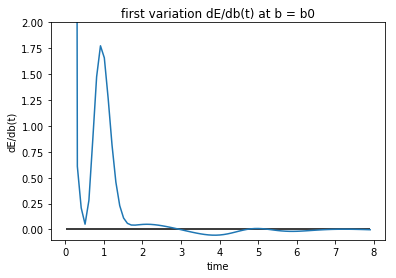

In [25]:
b = 18
a = 17
T = 8
times = np.arange(0.01, T, 0.1)
sb = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
sa = calc_sol(a, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
eb = np.array([energy((a,b)) for t,a,b in zip(sb.t, sb.y[0], sb.y[1])])
ea = np.array([energy((a,b)) for t,a,b in zip(sa.t, sa.y[0], sa.y[1])])
# deltay = [(y2 - y1) / ep for y1, y2 in zip(s1.y[0], s2.y[0])]
# delta = [t**4 * (e2 - e1) / ep for t, e1, e2 in zip(s1.t, e1, e2)]

# res = calc_event(b0, 8, at_right_well)

plt.plot(times, eb - ea)
# plt.plot(times, ea)
plt.ylim(-0.1, 2)
plt.hlines(0, times[0], times[-1])
# plt.vlines(res[0], 0, 2)
plt.xlabel("time")
plt.ylabel("dE/db(t)")
plt.title("first variation dE/db(t) at b = b0")

In [27]:
# plot of first variation of energy at ground state
b = b0
T = 8
ep = 1e-7
times = np.arange(0.01, T, 0.1)
s1 = calc_sol(b, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
s2 = calc_sol(b+ep, T, t_eval = times, rtol = 1e-8, atol = 1e-8)
e1 = np.array([energy((a,b)) for t,a,b in zip(s1.t, s1.y[0], s1.y[1])])
e2 = np.array([energy((a,b)) for t,a,b in zip(s2.t, s2.y[0], s2.y[1])])
deltay = [(y2 - y1) / ep for y1, y2 in zip(s1.y[0], s2.y[0])]
delta = [(e2 - e1) / ep for t, e1, e2 in zip(s1.t, e1, e2)]

res = calc_event(b0, 8, at_right_well)

plt.plot(times, delta)
plt.plot(times, deltay)
plt.ylim(-0.1, 10)
plt.hlines(0, times[0], times[-1])
plt.vlines(res[0], 0, 2)
plt.xlabel("time")
plt.ylabel("dE/db(t)")
plt.title("first variation dE/db(t) at b = b0")

NameError: name 'energy' is not defined

In [130]:
at_large_time(40)

-1.0476161471706913

In [131]:
calc_sol(40, 50, atol=1e-8, rtol=1e-8).y[0][-1]

-1.0476161471706913

In [134]:
eval_initial_cond(40, 0.01)

(38.9589762629598, -203.327138122539)

In [ ]:
a = 70 # 3**(0.25)+0.1
def my_force_old(y):
    return -2*y*((5-y)/sqrt(0.1+y**4)) * cos(y/5)**2
def my_force(y):
    y = abs(y)
    return -10*y*((20-10*y)/sqrt(0.2+(10*y)**4)) * cos(sqrt(10*y))**2
def my_force_scaled(s):
    return lambda y: my_force(s * y)
# s = calc_sol_arb(a, 20, make_ode_force(my_force))
# print(min(s.y[0]))
force_ode = make_ode_force(my_force_scaled(2))
plot_sol_arb(15, 100, force_ode, rtol=1e-6)
plt.hlines(0, 0, 50)



In [460]:
# width is 
def make_line(x0, x1, y0, y1):
        return (lambda x: (y0 + ((y1-y0)/(x1-x0)) * (x - x0)))
    
def make_zig_zag(num_negative,negative_width,negative_height,positive_width,positive_height, ep):
    last_neg = num_negative * negative_width
        
    ngleft = make_line(0, negative_width/2, 0, -negative_height) 
    ngright = make_line(negative_width/2, negative_width, -negative_height, 0) 
    ng1 = make_line(0, negative_width/2, -ep, -negative_height) 
    ng2 = make_line(negative_width/2, negative_width, -negative_height, -ep) 
    
    pgleft = make_line(0, positive_width/2, 0, positive_height) 
    pg1 = make_line(0, positive_width/2, ep, positive_height) 
    pg2 = make_line(positive_width/2, positive_width, positive_height, ep) 
    
    def negative_zig(y, ip):
        if y <= negative_width / 2:
            return ng1(y) if ip > 0 else ngleft(y)
        else:
            return ng2(y) if ip < (num_negative-1) else ngright(y)
    
    def positive_zig(y, ip):
        if y <= positive_width / 2:
            return pg1(y) if ip > 0 else pgleft(y)
        else:
            return pg2(y) 
        
    def zig_force(y):
        oy = y
        y = abs(y)
        v = 0
        if y <= last_neg:
            indp = floor(y / negative_width)
            yt = y - indp * negative_width
#             print(indp, yt)
            v = negative_zig(yt, indp)
            if indp % 2 == 1 and (indp+1)<num_negative:
                v = -ep
        else:
            a = y - last_neg
            indp = floor(a / positive_width)
            yt = a - indp * positive_width
            v = positive_zig(yt, indp) 
            if indp % 2 == 1:
                v = ep 
        return v if oy >= 0 else -v
    return zig_force

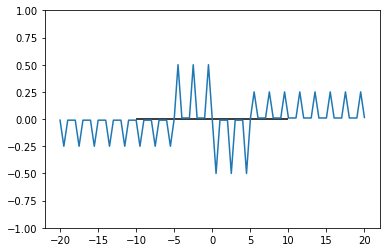

In [487]:
zf = make_zig_zag(5, 1, 0.5, 1, 0.25, 0.01)
def zfd(x): return (zf(x+0.001)-zf(x))/0.001
zig_ode = make_ode_force(zf)
xs = np.arange(-20, 20, 0.01)
ys = [zf(x) for x in xs]
ys2 = [x * zfd(x) - zf(x) for x in xs]
plt.plot(xs, ys)
# plt.plot(xs, ys2)
plt.ylim(-1, 1)
plt.hlines(0, -10, 10)

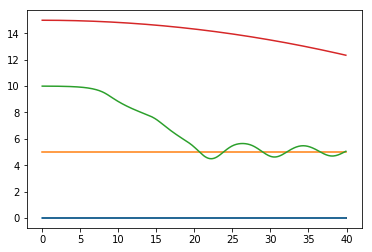

In [456]:
for b in np.arange(0, 20, 5):
    plot_sol_arb(b, 40, zig_ode)
plt.hlines(0, 0, 40)

Text(0.5, 1.0, 'Position at time 50 for various initial heights, showing excited states')

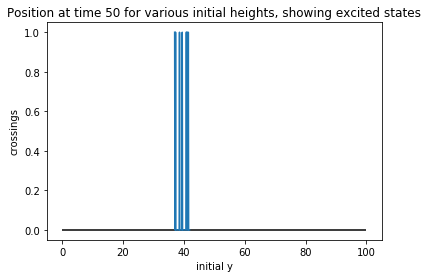

In [502]:
T = 150
def at_large_time_arb(b, ode, tol=1e-8):
    return calc_sol_arb(b, T, ode, atol=tol, rtol=tol).y[0][-1]

def num_crossings(b, ode, tol=1e-8):
    sol = solve_ivp(ode, [1e-5, T], [b, 0], events = at_0, dense_output = True, rtol=tol, atol=tol)
    return len(sol.t_events[0])

bs = np.arange(37, 42, 0.1)
ys = [num_crossings(b, zig_ode, tol=1e-8) for b in bs]
plt.plot(bs, ys)
plt.hlines(0, 0, 100)
plt.xlabel("initial y")
plt.ylabel("crossings")
plt.title("Position at time 50 for various initial heights, showing excited states")

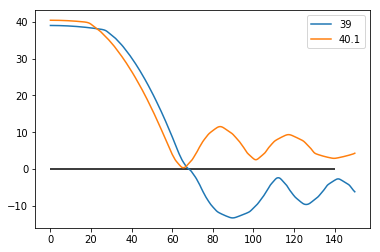

In [501]:
plot_sol_arb(39, 150, zig_ode, rtol=1e-10, atol=1e-10, lab="39")
plot_sol_arb(40.42, 150, zig_ode, rol=1e-10, atol=1e-10, lab="40.1")
plt.hlines(0, 0, 140)
# plt.ylim(-0.4, 0.5)
# plt.xlim(0, 80)
# plt.plot(np.arange(0, 10), np.arange(0, 10), label="l")
plt.legend()

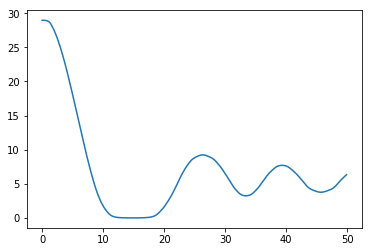

In [441]:
plot_sol_arb(28.976242, 50, zig_ode, rtol=1e-8, atol = 1e-8)

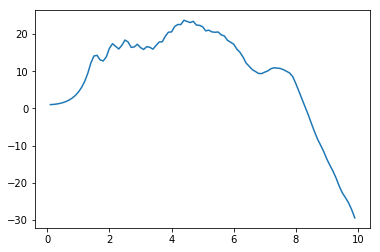

In [442]:
a = 28.976242
b = a + 1e-6
T = 10
times = np.arange(0.1, T, 0.1)
sa = calc_sol_arb(a, T, zig_ode, t_eval = times, atol=1e-8, rtol=1e-8)
sb = calc_sol_arb(b, T, zig_ode, t_eval = times, atol=1e-8, rtol=1e-8)
d = (sb.y[0] - sa.y[0]) / (b-a)
plt.plot(times, d)

No handles with labels found to put in legend.


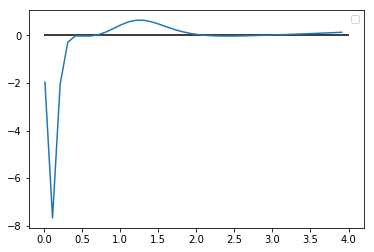

In [528]:
b = b1
ep = 1e-5
T = 4
t_eval = np.arange(0.01, T, 0.1)
s = calc_sol(b, T, t_eval, atol=1e-8, rtol = 1e-8)
s2 = calc_sol(b + ep, T, t_eval, atol=1e-8, rtol = 1e-8)

def f3(y): return y**3 - y

comp = [-t * f3(y)/2 for t, y in zip(s.t, s.y[0])]
delta = (s2.y[1] - s.y[1])/ep

# plt.plot(t_eval, s.y[1], label="velocity")
# plt.plot(t_eval, comp, label="velocity comp")
# plt.plot(t_eval, s.y[0])
plt.plot(t_eval, delta)
plt.hlines(0, 0, T)
plt.legend()

In [512]:
comp

[-3.5258828990214917, 1.2058298195620314]